In [ ]:
# import tensorflow
import tensorflow as tf

# notebook that uses RNNs for text spam detection

this notebook follows the text preproccessing notebook!

In [ ]:
# other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding
from tensorflow.keras.models import Model

In [ ]:
# get data (url doesn't work directly with pd.read_csv)
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-05-09 23:49:53--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.05s   

2023-05-09 23:49:54 (10.3 MB/s) - ‘spam.csv’ saved [503663/503663]



this file has a weird format, so you can't just look at the head like: !head spam.csv

instead, read it with pandas with a special encoding

In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


format looks weird, so let's drop the unnecessary columns (unnamed 2, 3, and 4)

In [ ]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# next, rename columns to something better
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


labels are just "ham" and "spam", but we want binary labels in order to do classification on this data.  

to fiz, we'll create a new column for the binary labels called "b_labels"

In [ ]:
# create binary labels column, where spam = 1 and not spam (ham) = 0
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})
Y = df['b_labels'].values 

In [ ]:
# split data into training and testing splits
df_train, df_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.3)

now that we have data (strings), need to convert the sentences to sequences, and map words to integers

this process is explained in the written notes!

In [ ]:
# sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [ ]:
# now word to integer mapping, see how many unique words (tokens) we have 
word2idx = tokenizer.word_index
v = len(word2idx)
print('found %s unique tokens' % v)

found 7431 unique tokens


In [ ]:
# pad train sequences to get an N x T matrix
data_train = pad_sequences(sequences_train)
print('shape of training tensor:', data_train.shape)

# sequence length T
T = data_train.shape[1]

shape of training tensor: (3900, 189)


In [ ]:
# pad test sequences 
# max length needs to be T to match train, so longer sentences will be truncated
data_test = pad_sequences(sequences_test, maxlen=T)
print('shape of testing tensor:', data_test.shape)

shape of testing tensor: (1672, 189)


now that the data is processed correctly, we can move to building the model

In [ ]:
# embedding dimensionality (D)
D = 20

# hidden state dimensionality (M)
M = 15

# note: want to use the size of the embedding to (V+1) x D as the first index
# starts at 1 instead of 0 -> zero used for padding!
# therefore if the final index of the emedding matrix is V, it'll really be V+1

# model
i = Input(shape=(T,))                  # takes sequences
x = Embedding(v+1, D)(i)               # takes sequences of integers & returns sequences of word vectors
x = LSTM(M, return_sequences=True)(x)  # RNN layer
x = GlobalMaxPooling1D()(x)            # global max pooling layer
x = Dense(1, activation='sigmoid')(x)  # output classification layer

model = Model(i, x)

In [ ]:
# compile & fit
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

r = model.fit(data_train, Y_train, 
              epochs=10,
              validation_data=(data_test, Y_test))

Epoch 1/10
122/122 [==============================] - 16s 99ms/step - loss: 0.4702 - accuracy: 0.8631 - val_loss: 0.3819 - val_accuracy: 0.8720
Epoch 2/10
122/122 [==============================] - 11s 93ms/step - loss: 0.3917 - accuracy: 0.8633 - val_loss: 0.3684 - val_accuracy: 0.8720
Epoch 3/10
122/122 [==============================] - 12s 100ms/step - loss: 0.3633 - accuracy: 0.8633 - val_loss: 0.3160 - val_accuracy: 0.8720
Epoch 4/10
122/122 [==============================] - 13s 105ms/step - loss: 0.2314 - accuracy: 0.8990 - val_loss: 0.1471 - val_accuracy: 0.9737
Epoch 5/10
122/122 [==============================] - 12s 100ms/step - loss: 0.1022 - accuracy: 0.9833 - val_loss: 0.1050 - val_accuracy: 0.9797
Epoch 6/10
122/122 [==============================] - 12s 101ms/step - loss: 0.0613 - accuracy: 0.9895 - val_loss: 0.0928 - val_accuracy: 0.9797
Epoch 7/10
122/122 [==============================] - 14s 113ms/step - loss: 0.0401 - accuracy: 0.9936 - val_loss: 0.0880 - val_accu

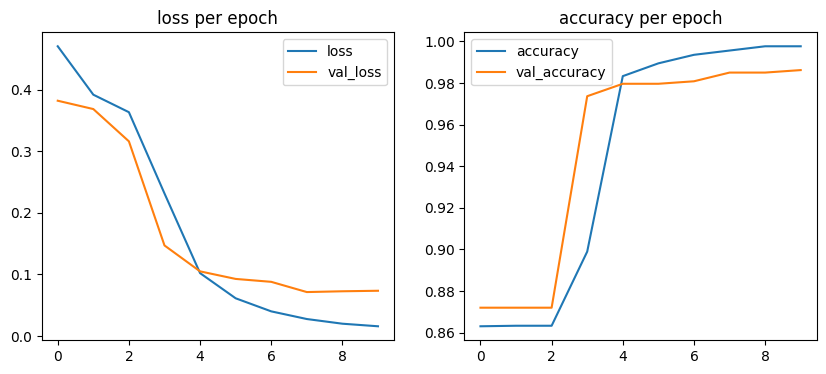

In [ ]:
# plot loss and accuracy 
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(r.history['loss'], label='loss')
ax[0].plot(r.history['val_loss'], label='val_loss')
ax[0].legend()
ax[0].set_title('loss per epoch')
ax[1].plot(r.history['accuracy'], label='accuracy')
ax[1].plot(r.history['val_accuracy'], label='val_accuracy')
ax[1].legend()
ax[1].set_title('accuracy per epoch')
plt.show()